In [9]:
pip uninstall tensorflow

Found existing installation: tensorflow 2.12.0
Uninstalling tensorflow-2.12.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.9/dist-packages/tensorflow-2.12.0.dist-info/*
    /usr/local/lib/python3.9/dist-packages/tensorflow/*
Proceed (Y/n)? Y
y
Y
  Successfully uninstalled tensorflow-2.12.0
Y


In [10]:
pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 2.7 MB/s eta 0:00:00


In [7]:
pip install --upgrade tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
from keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense,BatchNormalization, Flatten, MaxPool2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
from keras.utils import Sequence
from keras.backend import epsilon
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import cv2


from tqdm.notebook import tqdm_notebook as tqdm

import os

In [11]:
print(os.listdir("/content/input"))

['real_and_fake_face']


In [12]:
real = "/content/input/real_and_fake_face/training_real/"
fake = "/content/input/real_and_fake_face/training_fake/"

real_path = os.listdir(real)
fake_path = os.listdir(fake)

In [13]:
def load_img(path):
    image = cv2.imread(path)
    image = cv2.resize(image,(224, 224))
    return image[...,::-1]

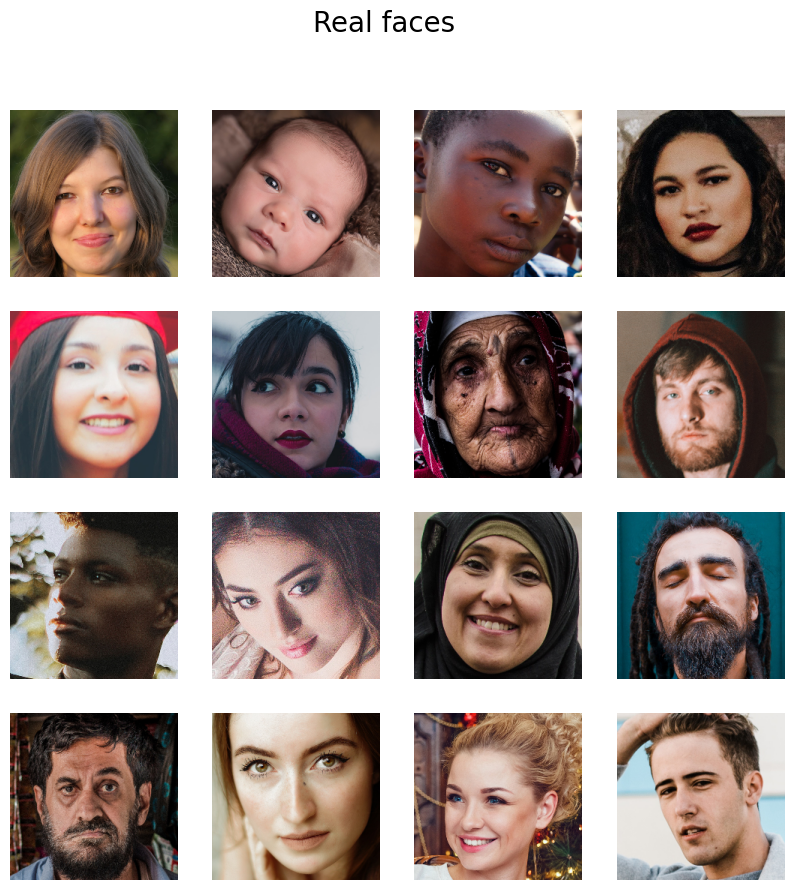

In [15]:
fig = plt.figure(figsize=(10, 10))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(load_img(real + real_path[i]), cmap='gray')
    plt.suptitle("Real faces",fontsize=20)
    plt.axis('off')

plt.show()

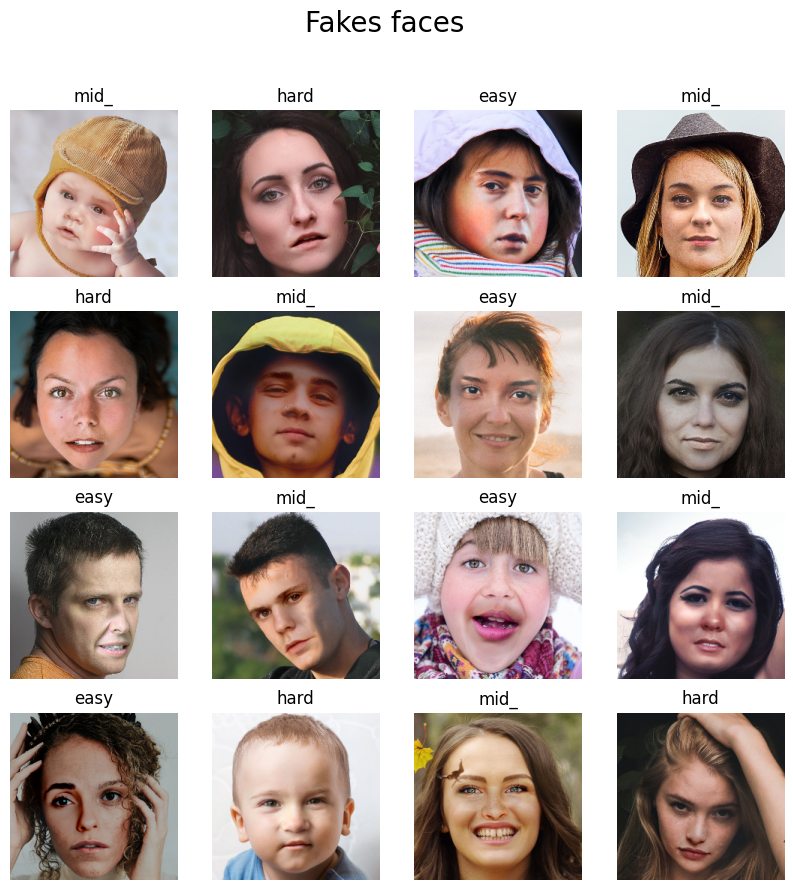

In [16]:
fig = plt.figure(figsize=(10,10))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(load_img(fake + fake_path[i]), cmap='gray')
    plt.suptitle("Fakes faces",fontsize=20)
    plt.title(fake_path[i][:4])
    plt.axis('off')

plt.show()

In [20]:
dataset_path = "/content/input/real_and_fake_face"

In [21]:
data_with_aug = ImageDataGenerator(horizontal_flip=True,
                                   vertical_flip=False,
                                   rescale=1./255,
                                  validation_split=0.2)

In [22]:
train = data_with_aug.flow_from_directory(dataset_path,
                                          class_mode="binary",
                                          target_size=(96, 96),
                                          batch_size=32,
                                          subset="training")

Found 1633 images belonging to 2 classes.


In [23]:
val = data_with_aug.flow_from_directory(dataset_path,
                                          class_mode="binary",
                                          target_size=(96, 96),
                                          batch_size=32,
                                          subset="validation"
                                          )

Found 408 images belonging to 2 classes.


**MobileNetV2**

In [24]:
mnet = MobileNetV2(include_top = False, weights = "imagenet" ,input_shape=(96,96,3))

9406464/9406464 [==============================] - 0s 0us/step


In [25]:
tf.keras.backend.clear_session()

model = Sequential([mnet,
                    GlobalAveragePooling2D(),
                    Dense(512, activation = "relu"),
                    BatchNormalization(),
                    Dropout(0.3),
                    Dense(128, activation = "relu"),
                    Dropout(0.1),
                    # Dense(32, activation = "relu"),
                    # Dropout(0.3),
                    Dense(2, activation = "softmax")])

model.layers[0].trainable = False

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics="accuracy")

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_96 (Functi  (None, 3, 3, 1280)       2257984   
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                        

In [26]:
def scheduler(epoch):
    if epoch <= 2:
        return 0.001
    elif epoch > 2 and epoch <= 15:
        return 0.0001 
    else:
        return 0.00001

lr_callbacks = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [27]:
hist = model.fit_generator(train,
                    epochs=20,
                    callbacks=[lr_callbacks],
                    validation_data=val)

<ipython-input-27-abeff273e3ad>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(train,


Epoch 1/20
52/52 [==============================] - 48s 829ms/step - loss: 0.9148 - accuracy: 0.5934 - val_loss: 1.1405 - val_accuracy: 0.5245 - lr: 0.0010
Epoch 2/20
52/52 [==============================] - 41s 778ms/step - loss: 0.5928 - accuracy: 0.7079 - val_loss: 1.1287 - val_accuracy: 0.5098 - lr: 0.0010
Epoch 3/20
52/52 [==============================] - 43s 826ms/step - loss: 0.4698 - accuracy: 0.7722 - val_loss: 1.0249 - val_accuracy: 0.5074 - lr: 0.0010
Epoch 4/20
52/52 [==============================] - 41s 784ms/step - loss: 0.3610 - accuracy: 0.8414 - val_loss: 1.0103 - val_accuracy: 0.5196 - lr: 1.0000e-04
Epoch 5/20
52/52 [==============================] - 41s 777ms/step - loss: 0.3506 - accuracy: 0.8445 - val_loss: 1.0674 - val_accuracy: 0.4828 - lr: 1.0000e-04
Epoch 6/20
52/52 [==============================] - 42s 809ms/step - loss: 0.3104 - accuracy: 0.8647 - val_loss: 1.0797 - val_accuracy: 0.4755 - lr: 1.0000e-04
Epoch 7/20
52/52 [==============================] - 

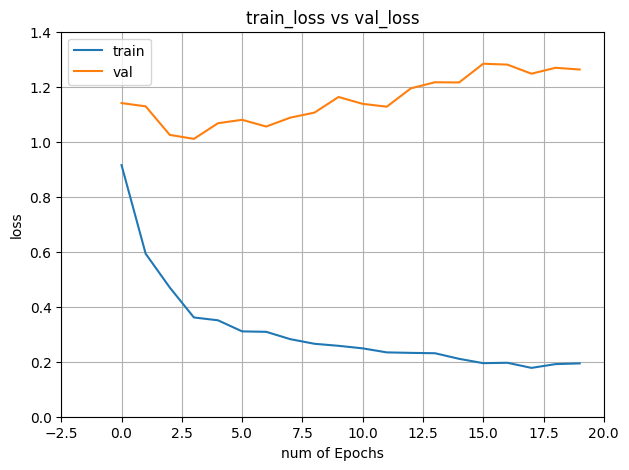

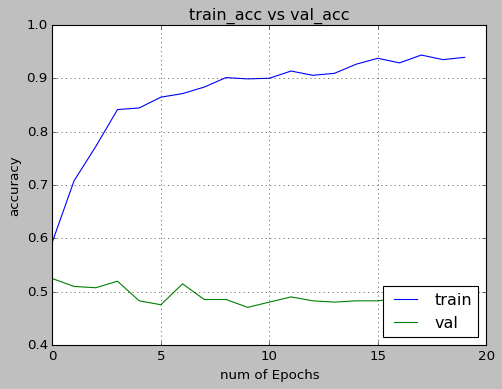

In [28]:
epochs = 20
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
xc = range(epochs)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

**VGG16 model**

In [29]:
train = data_with_aug.flow_from_directory(dataset_path,
                                          class_mode="binary",
                                          target_size=(224, 224),
                                          batch_size=98,
                                          subset="training")

val = data_with_aug.flow_from_directory(dataset_path,
                                          class_mode="binary",
                                          target_size=(224, 224),
                                          batch_size=98,
                                          subset="validation"
                                          )

Found 1633 images belonging to 2 classes.
Found 408 images belonging to 2 classes.


In [30]:
vgg16_model = tf.keras.applications.vgg16.VGG16(include_top=False, weights="imagenet", input_shape=(224,224,3))

58889256/58889256 [==============================] - 0s 0us/step


In [31]:
vgg16_model.output[-1]

<KerasTensor: shape=(7, 7, 512) dtype=float32 (created by layer 'tf.__operators__.getitem')>

In [32]:
# model = Sequential()
# for layer in vgg16_model.layers[:-1]:
#     model.add(layer)

# for layer in model.layers:
#     layer.trainable = False
    
# model.add(Dense(2, activation='softmax'))


model = Sequential([vgg16_model,
                    Flatten(),
#                     GlobalAveragePooling2D(),
#                     Dense(512, activation = "relu"),
#                     BatchNormalization(),
#                     Dropout(0.3),
#                     Dense(128, activation = "relu"),
#                     Dropout(0.1),
#                     # Dense(32, activation = "relu"),
#                     # Dropout(0.3),
                    Dense(2, activation = "softmax")])

model.layers[0].trainable = False

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics="accuracy")

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense_3 (Dense)             (None, 2)                 50178     
                                                                 
Total params: 14,764,866
Trainable params: 50,178
Non-trainable params: 14,714,688
_________________________________________________________________


In [34]:
hist =  model.fit_generator(train,
                    epochs=5,
                    callbacks=[lr_callbacks],
                    validation_data=val)

<ipython-input-34-ea3365b6907f>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist =  model.fit_generator(train,


Epoch 1/5
17/17 [==============================] - 1467s 87s/step - loss: 0.7824 - accuracy: 0.6289 - val_loss: 0.9212 - val_accuracy: 0.5490 - lr: 0.0010
Epoch 2/5
17/17 [==============================] - 1433s 85s/step - loss: 0.5314 - accuracy: 0.7318 - val_loss: 0.8116 - val_accuracy: 0.5539 - lr: 0.0010
Epoch 3/5
17/17 [==============================] - 1421s 85s/step - loss: 0.4766 - accuracy: 0.7685 - val_loss: 0.8035 - val_accuracy: 0.5441 - lr: 0.0010
Epoch 4/5
17/17 [==============================] - 1417s 84s/step - loss: 0.4297 - accuracy: 0.8028 - val_loss: 0.8321 - val_accuracy: 0.5613 - lr: 1.0000e-04
Epoch 5/5
17/17 [==============================] - 1402s 83s/step - loss: 0.4272 - accuracy: 0.8200 - val_loss: 0.8446 - val_accuracy: 0.5637 - lr: 1.0000e-04


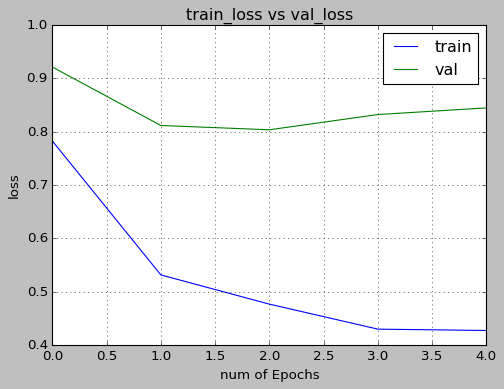

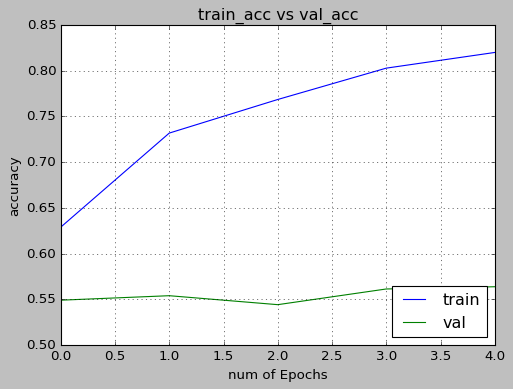

In [36]:
epochs = 5
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
xc = range(epochs)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

In [37]:
#Creating an array of predicted test images

predictions = model.predict_generator(val)

<ipython-input-37-a5c5724c89c6>:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(val)


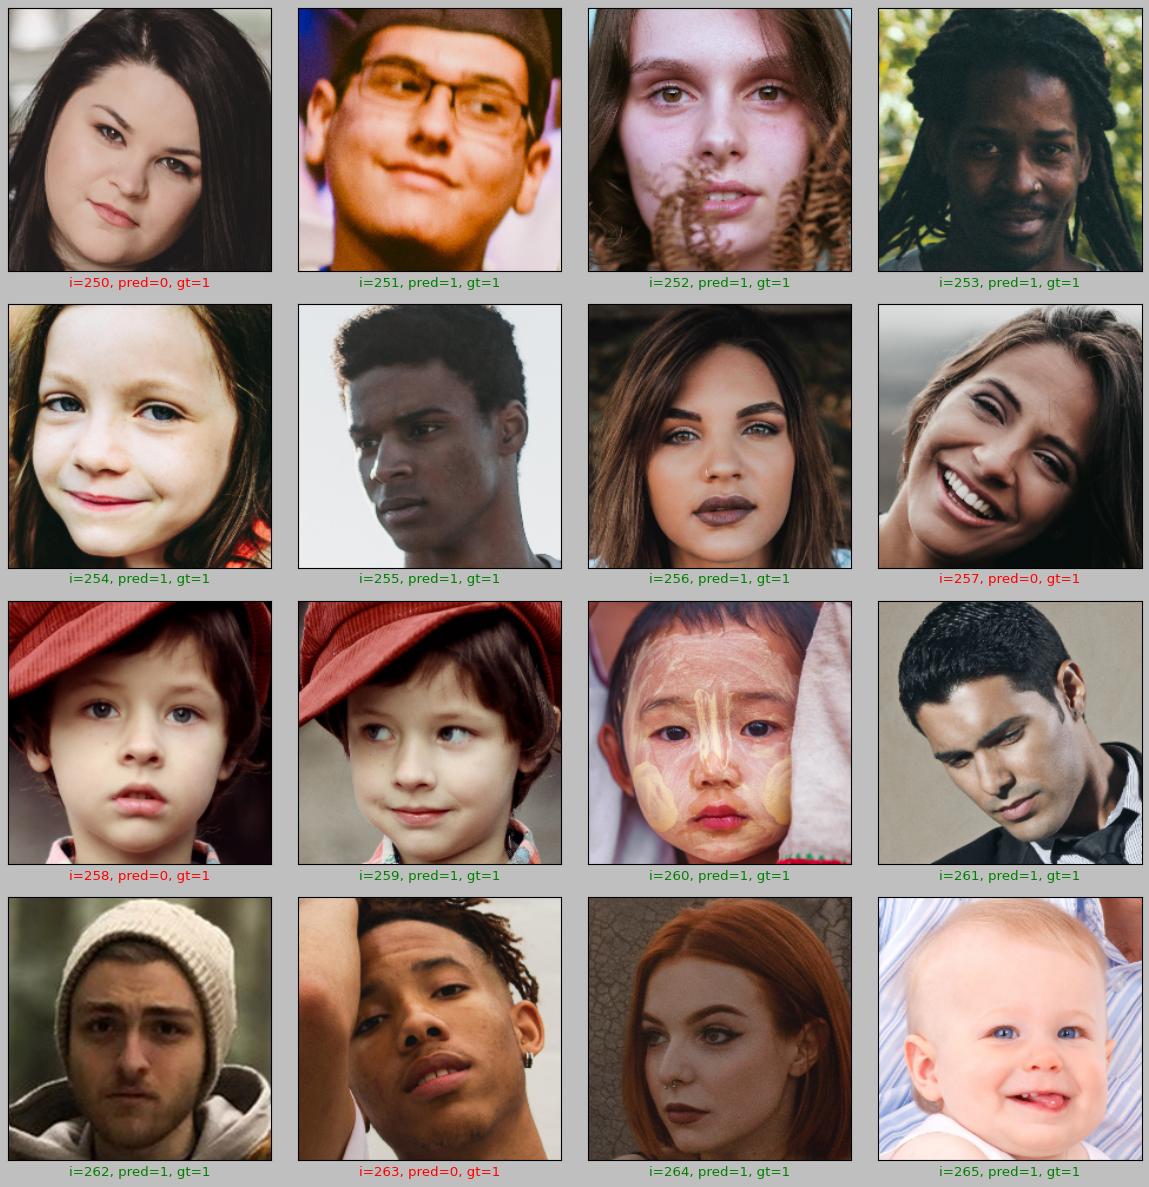

In [38]:
val_path = "/content/input/real_and_fake_face/"

plt.figure(figsize=(15,15))

start_index = 250

for i in range(16):
  plt.subplot(4,4, i+1)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  preds = np.argmax(predictions[[start_index+i]])
    
  gt = val.filenames[start_index+i][9:13]

  
  if gt == "fake":
    gt = 0
  else:
    gt = 1
    
  if preds != gt:
    col ="r"
  else:
    col = "g"

  plt.xlabel('i={}, pred={}, gt={}'.format(start_index+i,preds,gt),color=col)
  plt.imshow(load_img(val_path+val.filenames[start_index+i]))
  plt.tight_layout()

plt.show()